In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import load_item, show_grasp
from dataset import ToyGraspDataset
import torch

%load_ext autoreload
%autoreload 2


np.random.seed(10)
torch.manual_seed(10)

Outline
1. Make datasets
2. Train Network
3. Save results

In [3]:
item = load_item('fork')

In [21]:
dataset = ToyGraspDataset(root='data', name='train_data', size=1200, dataset='sim2real')
sim_dataset = ToyGraspDataset(root='data', size=1200, dataset='sim2sim')

sim2real!!!


In [22]:
pos_ind = np.argwhere(dataset.data[:,2] == 1)
neg_ind = np.argwhere(dataset.data[:,2] == 0)

pos_ind = np.random.choice(pos_ind.squeeze(), 5)
neg_ind = np.random.choice(neg_ind.squeeze(), 5)


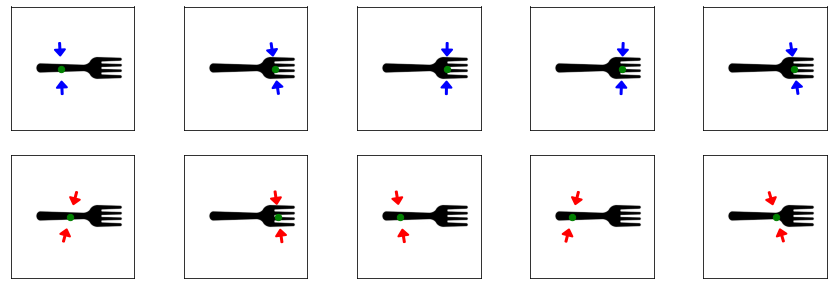

In [23]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15,5))

for i in range(5):
    ax[0][i].imshow(item, cmap='Greys')
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    sample = dataset.data[pos_ind[i]]
    show_grasp(ax[0][i], sample[0], sample[1], sample[2] )
    ax[1][i].imshow(item, cmap='Greys')
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    sample = dataset.data[neg_ind[i]]
    show_grasp(ax[1][i], sample[0], sample[1], sample[2] )

In [24]:
# show the data
data = dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks

sim_data = sim_dataset.data
pos_sim_masks = sim_data[:,2] == 1
neg_sim_masks = ~pos_sim_masks

# handle_masks = data[:,3] == 1
# pos_combined_masks = handle_masks & pos_masks
# neg_combined_masks = handle_masks & neg_masks

In [25]:
np.unique(data[:,1])

array([1.2228258, 1.229305 , 1.229386 , ..., 5.052319 , 5.0574274,
       5.0605655], dtype=float32)

In [26]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
# ax[0].scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='g')
# ax[0].scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='b')
# ax[0].scatter(sim_data[neg_sim_masks][:,0], sim_data[neg_sim_masks][:,1], marker='.', alpha=1.0, color='r')
# ax[0].set_title('Sim+ vs Real+')
# ax[0].set_xlabel('Grasp center')
# ax[0].set_ylabel('Grasp angle')

# ax[1].scatter(sim_data[pos_sim_masks][:,0], sim_data[pos_sim_masks][:,1], marker='.', alpha=1.0, color='b')
# ax[1].scatter(sim_data[neg_sim_masks][:,0], sim_data[neg_sim_masks][:,1], marker='.', alpha=1.0, color='r')
# ax[1].set_title('Sim+ vs Sim-')
# ax[1].set_xlabel('Grasp center')
# ax[1].set_ylabel('Grasp angle')

# plt.show()

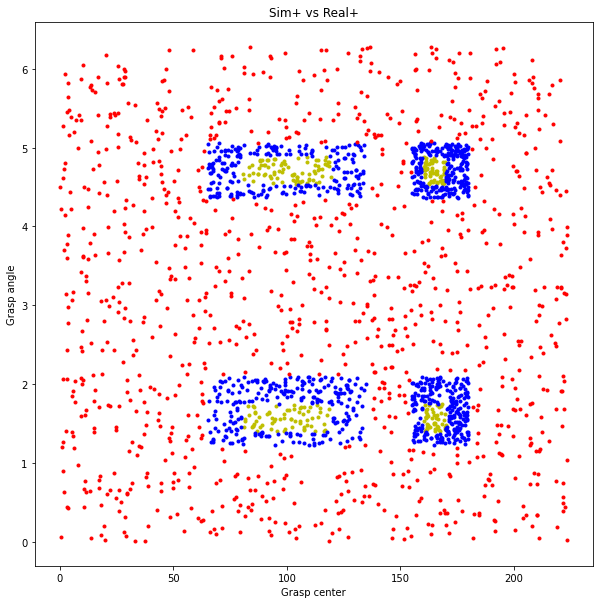

In [28]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='y')
ax1.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.scatter(sim_data[neg_sim_masks][:,0], sim_data[neg_sim_masks][:,1], marker='.', alpha=1.0, color='r')
# ax1.scatter(sim_data[pos_sim_masks][:,0], sim_data[pos_sim_masks][:,1], marker='.', alpha=1.0, color='g')
ax1.set_title('Sim+ vs Real+')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')

plt.show()

# Sim+ vs Real+ (using simple NN)

In [52]:
from torch.utils.data import TensorDataset, DataLoader
from network import ClassifierNN, train_network, save_model_info, load_model_info
import torch.optim as optim

torch.manual_seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [53]:
# train classifier
train_dataset = ToyGraspDataset(root='data', name='train_data', size=10000, is_pos_label=True, device=device, dataset='sim2real')
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='test_data', size=25, is_pos_label=True, device=device, dataset='sim2real')
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

sim2real!!!


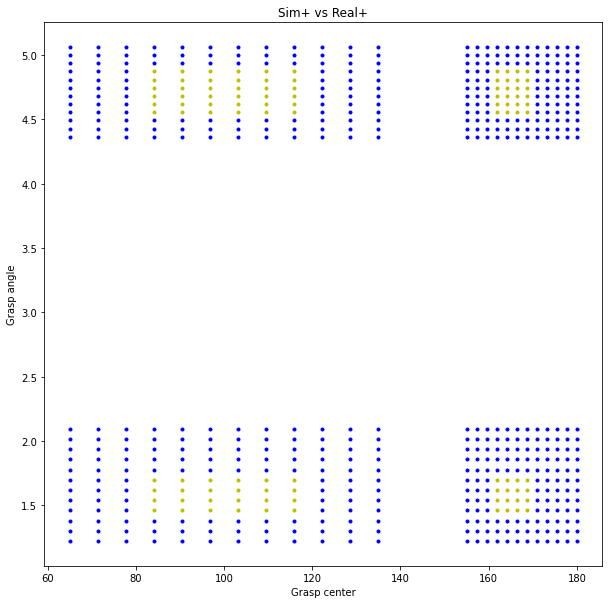

In [54]:
data = test_dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='y')
ax1.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.set_title('Sim+ vs Real+')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')

plt.show()

In [58]:
# first classifier balanced
# f = ClassifierNN([2,64,64,1])
f = ClassifierNN([2,32,32,1])
f = f.to(device)
optimizer = optim.Adam(f.parameters(), lr=0.001)

In [59]:
f, info = train_network(f, train_dataloader, train_dataset,
                                      test_dataloader, test_dataset,
                                      n_epochs=1000, print_freq=40, optimizer=optimizer)
info['pos_samples_size'] = np.sum(train_dataset.data[:,2])
info['neg_samples_size'] = train_dataset.data.shape[0] - np.sum(train_dataset.data[:,2])
save_model_info(f, info, name='simvsreal_10k')

Epoch: 40
Train loss: 0.0023196763277053833 | Test losses: 0.002012952541311582
Train acc: 0.4393 | Test acc: 0.4270833333333333
Epoch: 80
Train loss: 0.002057855385541916 | Test losses: 0.0017609008484416539
Train acc: 0.6076 | Test acc: 0.5885416666666666
Epoch: 120
Train loss: 0.0019145853936672211 | Test losses: 0.0015890679011742275
Train acc: 0.6525 | Test acc: 0.6180555555555556
Epoch: 160
Train loss: 0.0017899120330810547 | Test losses: 0.0014931559562683105
Train acc: 0.68 | Test acc: 0.5954861111111112
Epoch: 200
Train loss: 0.001637802916765213 | Test losses: 0.0013791128165192073
Train acc: 0.7047 | Test acc: 0.65625
Epoch: 240
Train loss: 0.001525869220495224 | Test losses: 0.0012661833316087723
Train acc: 0.7288 | Test acc: 0.640625
Epoch: 280
Train loss: 0.0014338105916976928 | Test losses: 0.0011877688682741588
Train acc: 0.7433 | Test acc: 0.6545138888888888
Epoch: 320
Train loss: 0.0013581575691699983 | Test losses: 0.0011062686228089863
Train acc: 0.7597 | Test acc: 

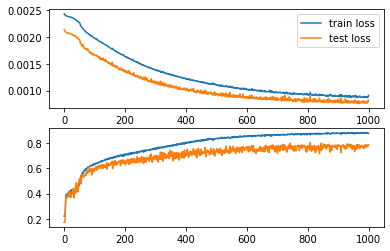

In [60]:
fig, ax = plt.subplots(2)
ax[0].plot(info['train_loss'], label='train loss')
ax[0].plot(info['test_loss'], label='test loss')

ax[0].legend()
ax[1].plot(info['train_acc'], label='Train')
ax[1].plot(info['test_acc'], label='Test')
plt.show()

### Sim+ vs Real+ (using GP Classifier)

In [186]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [110]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


In [111]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.948   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.917   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.882   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.844   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.801   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.752   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.699   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.645   lengthscale: 0.405   noise: 0.402
Iter 9/50 - Loss: 0.593   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.546   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.504   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.465   lengthscale: 0.291   noise: 0.284
Iter 13/50 - Loss: 0.429   lengthscale: 0.271   noise: 0.259
Iter 14/50 - Loss: 0.393   lengthscale: 0.255   noise: 0.236
Iter 15/50 - Loss: 0.359   lengthscale: 0.241   noise: 0.215
Iter 16/50 - Loss: 0.325   lengthscale: 0.230   noise: 0.196
Iter 17/50 - Loss: 0.291   length

In [112]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

NameError: name 'test_x' is not defined

In [113]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

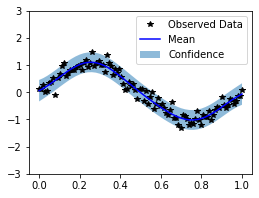

In [114]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

